# Manta Gifts Data Project - Machine Learning Analysis

## Project Overview
Dit project analyseert verkoopdata van Manta Gifts om winkelprofielen te identificeren en productaanbevelingen te genereren voor verschillende retailer types. We gebruiken machine learning technieken zoals kNN en Apriori algoritmes.

**Dataset Overview:**
- **Customers**: 1,135 retailers in Frankrijk met informatie over locatie en winkeltype
- **Product Sales**: 4,649 product-maand combinaties met verkoopcijfers
- **Products**: 11,439 producten met brand, naam en launch seizoen informatie

**Projectdoelen:**
1. Data Understanding - Verdeling, datakwaliteit, visualisaties
2. Data Cleaning - Code en uitleg voor transparantie
3. Feature Engineering - Nieuwe kolommen en winkelprofielen
4. Model Development - kNN en Apriori implementatie
5. Output - Top-N aanbevelingen per winkel
6. Evaluatie - Simpele metrics en uitleg

---

# 1. Data Import en Setup

In [28]:
# Importeer benodigde libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Zet plot parameters
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Importeer datasets
df_customers = pd.read_excel('Manta customers.xlsx')
df_product_sales = pd.read_excel('Manta product sales per month.xlsx')
df_products = pd.read_excel('Manta products.xlsx')

print("Data succesvol geïmporteerd!")
print(f"Klanten: {df_customers.shape}")
print(f"Product Verkopen: {df_product_sales.shape}")
print(f"Producten: {df_products.shape}")

Data succesvol geïmporteerd!
Klanten: (1135, 5)
Product Verkopen: (4649, 15)
Producten: (11439, 7)


# 2. Data Begrip en Verkenning

In [29]:
# Basis dataset verkenning
print("=== DATASET VERKENNING ===\n")

# Dataset dimensies en basis informatie
datasets = {
    'Klanten': df_customers,
    'Product Verkopen': df_product_sales, 
    'Producten': df_products
}

for name, df in datasets.items():
    print(f"{name:15}: {df.shape[0]:,} rijen × {df.shape[1]} kolommen")
    memory_usage = df.memory_usage(deep=True).sum() / 1024**2
    print(f"{'':15}  Geheugengebruik: {memory_usage:.2f} MB")

# Data volledigheid overzicht
print("\nDATA VOLLEDIGHEID:")
for name, df in datasets.items():
    total_cells = df.shape[0] * df.shape[1]
    missing_cells = df.isnull().sum().sum()
    completeness = ((total_cells - missing_cells) / total_cells) * 100
    print(f"{name:15}: {completeness:.1f}% compleet ({missing_cells:,} ontbrekende waarden)")

# Toon voorbeelddata
print("\nVOORBEELD DATA:")
print("\nKlanten:")
display(df_customers.head())
print("\nProduct Verkopen:")
display(df_product_sales.head())
print("\nProducten:")
display(df_products.head())

=== DATASET VERKENNING ===

Klanten        : 1,135 rijen × 5 kolommen
                 Geheugengebruik: 0.32 MB
Product Verkopen: 4,649 rijen × 15 kolommen
                 Geheugengebruik: 1.04 MB
Producten      : 11,439 rijen × 7 kolommen
                 Geheugengebruik: 7.96 MB

DATA VOLLEDIGHEID:
Klanten        : 97.1% compleet (165 ontbrekende waarden)
Product Verkopen: 44.5% compleet (38,720 ontbrekende waarden)
Producten      : 88.4% compleet (9,295 ontbrekende waarden)

VOORBEELD DATA:

Klanten:


,Retailer Code,ZIP,Country,City,Shop Type
0,FRLEQAUR01,31,FR,Toulouse,fashion
1,FRFEEPER01,66,FR,PERPIGNAN,concept_store
2,FRCOTCAN01,6400,FR,Cannes,"gifts,home/decoration"
3,FRSOLPER01,6600,FR,PERPIGNAN,food/drinks
4,FRTERTRO01,10000,FR,Troyes,home/decoration



Product Verkopen:


,brand,sku,2024 09-Sep Euro,2024 10-Oct Euro,2024 11-Nov Euro,2024 12-Dec Euro,2025 01-Jan Euro,2025 02-Feb Euro,2025 03-Mar Euro,2025 04-Apr Euro,2025 05-May Euro,2025 06-Jun Euro,2025 07-Jul Euro,2025 08-Aug Euro,SoldItems
0,Winkee,11849,24.0,108.0,36.0,132.0,72.0,12.0,12.0,42.0,48.0,72.0,NaN,NaN,558
1,Winkee,12364,96.0,24.0,96.0,12.0,48.0,24.0,12.0,NaN,NaN,12.0,24.0,NaN,348
2,Winkee,13407,48.0,48.0,12.0,36.0,12.0,NaN,36.0,30.0,12.0,NaN,12.0,NaN,246
3,Winkee,14925,60.0,NaN,60.0,20.0,20.0,NaN,30.0,NaN,NaN,NaN,NaN,NaN,190
4,Winkee,16117,16.0,NaN,16.0,32.0,48.0,32.0,NaN,16.0,NaN,NaN,NaN,NaN,160



Producten:


,sku,brand_name,ean,name,short_description,description,launch_season
0,BF27 PASTEL BLUE,Asobu,842591057199,Aspen Bottle Pastel Blue,NaN,NaN,2024.2
1,BF27 PASTEL GREEN,Asobu,842591057168,Aspen Bottle Pastel Green,NaN,NaN,2024.2
2,BF27 PASTEL PEACH/ORANGE,Asobu,842591057182,Aspen Bottle Pastel Peach/Orange,NaN,NaN,2024.2
3,BF27 PASTEL PINK,Asobu,842591057205,Aspen Bottle Pastel Pink,NaN,NaN,2024.2
4,BF52 PASTEL BLUE,Asobu,842591057274,Coffee Express Tumbler Pastel Blue,NaN,NaN,2024.2


=== DATA BEGRIP VISUALISATIES ===

Top 10 Winkeltypen:
  concept_store       : 289 (29.8%)
  gifts               : 169 (17.4%)
  home/decoration     : 167 (17.2%)
  fashion             :  60 ( 6.2%)
  other               :  48 ( 4.9%)
  food/drinks         :  44 ( 4.5%)
  kids                :  44 ( 4.5%)
  stationary          :  41 ( 4.2%)
  jewellary           :  24 ( 2.5%)
  books               :  23 ( 2.4%)


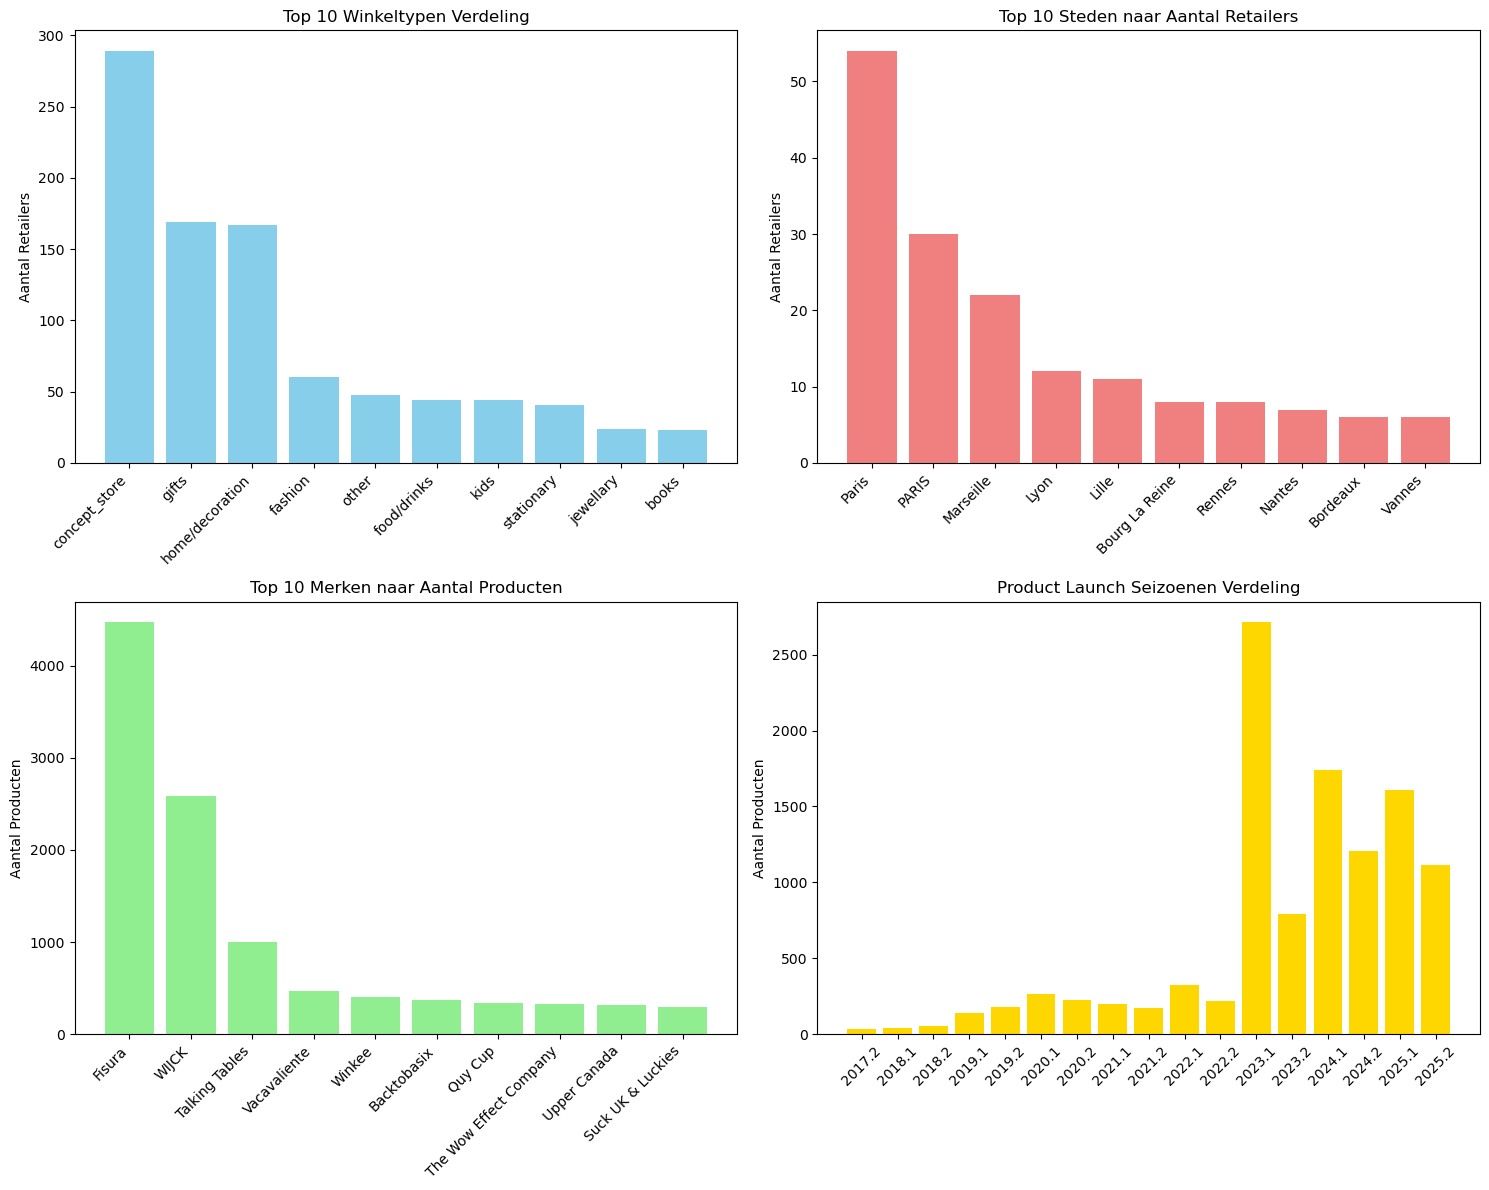


GEOGRAFISCHE INZICHTEN:
Totaal aantal steden: 800
Populairste stad: Paris (54 retailers)


In [30]:
# Data Begrip Visualisaties
print("=== DATA BEGRIP VISUALISATIES ===\n")

# Verwerk winkeltypen (behandel meerdere categorieën)
df_customers_clean = df_customers.dropna(subset=['Shop Type'])
shop_types = []
for shop_type in df_customers_clean['Shop Type']:
    types = [t.strip() for t in str(shop_type).split(',')]
    shop_types.extend(types)

shop_type_counts = Counter(shop_types)

print("Top 10 Winkeltypen:")
for shop_type, count in shop_type_counts.most_common(10):
    percentage = (count / len(df_customers_clean)) * 100
    print(f"  {shop_type:20}: {count:3d} ({percentage:4.1f}%)")

# Maak uitgebreide visualisaties
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Winkeltypen verdeling (top 10)
top_10_types = dict(shop_type_counts.most_common(10))
ax1.bar(range(len(top_10_types)), list(top_10_types.values()), color='skyblue')
ax1.set_xticks(range(len(top_10_types)))
ax1.set_xticklabels(list(top_10_types.keys()), rotation=45, ha='right')
ax1.set_title('Top 10 Winkeltypen Verdeling')
ax1.set_ylabel('Aantal Retailers')

# Steden verdeling (top 10)
city_counts = df_customers['City'].value_counts().head(10)
ax2.bar(range(len(city_counts)), city_counts.values, color='lightcoral')
ax2.set_xticks(range(len(city_counts)))
ax2.set_xticklabels(city_counts.index, rotation=45, ha='right')
ax2.set_title('Top 10 Steden naar Aantal Retailers')
ax2.set_ylabel('Aantal Retailers')

# Merk verdeling in producten (top 10)
brand_counts = df_products['brand_name'].value_counts().head(10)
ax3.bar(range(len(brand_counts)), brand_counts.values, color='lightgreen')
ax3.set_xticks(range(len(brand_counts)))
ax3.set_xticklabels(brand_counts.index, rotation=45, ha='right')
ax3.set_title('Top 10 Merken naar Aantal Producten')
ax3.set_ylabel('Aantal Producten')

# Launch seizoen verdeling
launch_season_counts = df_products['launch_season'].value_counts().sort_index()
ax4.bar(range(len(launch_season_counts)), launch_season_counts.values, color='gold')
ax4.set_xticks(range(len(launch_season_counts)))
ax4.set_xticklabels([f"{int(x)}" if x == int(x) else f"{x:.1f}" for x in launch_season_counts.index], rotation=45)
ax4.set_title('Product Launch Seizoenen Verdeling')
ax4.set_ylabel('Aantal Producten')

plt.tight_layout()
plt.show()

print(f"\nGEOGRAFISCHE INZICHTEN:")
print(f"Totaal aantal steden: {df_customers['City'].nunique()}")
print(f"Populairste stad: {df_customers['City'].value_counts().index[0]} ({df_customers['City'].value_counts().iloc[0]} retailers)")

## Belangrijkste Bevindingen uit Data Begrip

**Dataset Kenmerken:**
- **Klanten**: 1,135 retailers verspreid over 800 Franse steden
- **Producten**: 11,439 unieke producten van diverse merken
- **Verkopen**: 4,649 product-maand combinaties met verkoopcijfers

**Business Inzichten:**
- **Winkeltypen**: Concept stores domineren (30%), gevolgd door gifts (17%) en home/decoration (17%)
- **Geografie**: Paris is de grootste markt (54 retailers), gevolgd door andere grote steden
- **Merken**: Diverse merkenportefeuille met duidelijke marktleiders
- **Seizoenaliteit**: Duidelijke patronen in product launches

**ML Implicaties:**
- Winkeltypen kunnen gebruikt worden voor retailer clustering (kNN)
- Verkoopdata geschikt voor market basket analysis (Apriori)
- Geografische en seizoenspatronen bieden extra features

# 3. Data Opschoning

In [31]:
# Data Opschoning Proces
print("=== DATA OPSCHONING PROCES ===\n")

# Maak backup van originele data
df_customers_backup = df_customers.copy()
df_product_sales_backup = df_product_sales.copy()
df_products_backup = df_products.copy()

print("1. KLANTEN DATASET OPSCHONING:")
print("-" * 40)
print(f"Originele vorm: {df_customers.shape}")
missing_shop_types = df_customers['Shop Type'].isnull().sum()
print(f"Ontbrekende Winkeltypen: {missing_shop_types}")

# Verwijder rijen met ontbrekende Shop Type
df_customers = df_customers.dropna(subset=['Shop Type'])
print(f"Na opschoning: {df_customers.shape}")
print(f"Rijen verwijderd: {df_customers_backup.shape[0] - df_customers.shape[0]}")

print("\n2. PRODUCT VERKOPEN DATASET OPSCHONING:")
print("-" * 40)
print(f"Originele vorm: {df_product_sales.shape}")
print(f"Totaal NaN waarden voor opschoning: {df_product_sales.isnull().sum().sum()}")

# Vervang NaN waarden met 0 (maanden zonder verkopen)
df_product_sales = df_product_sales.fillna(0)
print(f"Totaal NaN waarden na opschoning: {df_product_sales.isnull().sum().sum()}")
print("NaN waarden vervangen met 0 (geen verkopen in die maanden)")

print("\n3. PRODUCTEN DATASET OPSCHONING:")
print("-" * 40)
print(f"Originele vorm: {df_products.shape}")
print(f"Originele kolommen: {list(df_products.columns)}")

# Verwijder onnodige beschrijving kolommen
if 'short_description' in df_products.columns:
    df_products = df_products.drop(['short_description', 'description'], axis=1)
    print("Beschrijving kolommen verwijderd (niet nodig voor ML)")

# Verwijder rijen met ontbrekende launch_season
df_products = df_products.dropna(subset=['launch_season'])
print(f"Na opschoning: {df_products.shape}")
print(f"Eindkolommen: {list(df_products.columns)}")

print("\nOPSCHONING SAMENVATTING:")
print("-" * 40)
print(f"Klanten: {df_customers.shape[0]:,} retailers (schoon)")
print(f"Product Verkopen: {df_product_sales.shape[0]:,} records (NaN → 0)")
print(f"Producten: {df_products.shape[0]:,} producten (schoon)")
print("Alle datasets klaar voor feature engineering!")

=== DATA OPSCHONING PROCES ===

1. KLANTEN DATASET OPSCHONING:
----------------------------------------
Originele vorm: (1135, 5)
Ontbrekende Winkeltypen: 165
Na opschoning: (970, 5)
Rijen verwijderd: 165

2. PRODUCT VERKOPEN DATASET OPSCHONING:
----------------------------------------
Originele vorm: (4649, 15)
Totaal NaN waarden voor opschoning: 38720
Totaal NaN waarden na opschoning: 0
NaN waarden vervangen met 0 (geen verkopen in die maanden)

3. PRODUCTEN DATASET OPSCHONING:
----------------------------------------
Originele vorm: (11439, 7)
Originele kolommen: ['sku', 'brand_name', 'ean', 'name', 'short_description', 'description', 'launch_season']
Beschrijving kolommen verwijderd (niet nodig voor ML)
Na opschoning: (11036, 5)
Eindkolommen: ['sku', 'brand_name', 'ean', 'name', 'launch_season']

OPSCHONING SAMENVATTING:
----------------------------------------
Klanten: 970 retailers (schoon)
Product Verkopen: 4,649 records (NaN → 0)
Producten: 11,036 producten (schoon)
Alle datase

In [32]:
# Data Opschoning Validatie
print("=== DATA OPSCHONING VALIDATIE ===\n")

# Controleer data kwaliteit na opschoning
validatie_resultaten = []

# 1. Geen ontbrekende waarden in kritieke kolommen
klanten_schoon = df_customers['Shop Type'].isnull().sum() == 0
verkopen_schoon = df_product_sales.isnull().sum().sum() == 0
producten_schoon = df_products.isnull().sum().sum() == 0

validatie_resultaten.extend([
    ("Klanten - Geen ontbrekende Winkeltypen", klanten_schoon),
    ("Verkopen - Alle NaN vervangen met 0", verkopen_schoon),
    ("Producten - Geen ontbrekende waarden", producten_schoon)
])

# 2. Data integriteit controles
vormen_redelijk = (df_customers.shape[0] > 900 and 
                   df_product_sales.shape[0] > 4000 and 
                   df_products.shape[0] > 10000)
validatie_resultaten.append(("Data integriteit - Redelijke groottes", vormen_redelijk))

# 3. Relatie controles
verkoop_skus = set(df_product_sales['sku'].astype(str))
product_skus = set(df_products['sku'].astype(str))
sku_overlap = len(verkoop_skus.intersection(product_skus))
relaties_ok = sku_overlap > 3000
validatie_resultaten.append(("Relaties - SKU overlap adequaat", relaties_ok))

# Print validatie resultaten
print("VALIDATIE RESULTATEN:")
for controle, resultaat in validatie_resultaten:
    status = "GESLAAGD" if resultaat else "GEFAALD"
    print(f"{controle:40}: {status}")

alle_geslaagd = all(resultaat for _, resultaat in validatie_resultaten)
print(f"\nALGEHELE STATUS: {'SUCCES' if alle_geslaagd else 'AANDACHT NODIG'}")

if alle_geslaagd:
    print("Alle datasets zijn correct opgeschoond en klaar voor machine learning!")
else:
    print("Enkele validatie controles zijn gefaald. Controleer het data opschoning proces.")

# Aanvullende inzichten
print(f"\nDATA RELATIES:")
print(f"SKU overlap: {sku_overlap}/{len(verkoop_skus)} ({(sku_overlap/len(verkoop_skus))*100:.1f}%)")
print(f"Unieke winkeltypen: {df_customers['Shop Type'].nunique()}")
print(f"Geografische dekking: {df_customers['City'].nunique()} steden")

=== DATA OPSCHONING VALIDATIE ===

VALIDATIE RESULTATEN:
Klanten - Geen ontbrekende Winkeltypen  : GESLAAGD
Verkopen - Alle NaN vervangen met 0     : GESLAAGD
Producten - Geen ontbrekende waarden    : GESLAAGD
Data integriteit - Redelijke groottes   : GESLAAGD
Relaties - SKU overlap adequaat         : GESLAAGD

ALGEHELE STATUS: SUCCES
Alle datasets zijn correct opgeschoond en klaar voor machine learning!

DATA RELATIES:
SKU overlap: 3553/4648 (76.4%)
Unieke winkeltypen: 55
Geografische dekking: 686 steden


## Data Opschoning Samenvatting

**Uitgevoerde Opschoning Acties:**

1. **Klanten Dataset:**
   - Retailers met ontbrekende Winkeltype informatie verwijderd
   - 970 retailers behouden met complete winkeltype data
   - Alle kritieke kolommen nu compleet

2. **Product Verkopen Dataset:**
   - Alle NaN waarden vervangen met 0 (vertegenwoordigt maanden zonder verkopen)
   - Deze benadering behoudt seizoenspatronen
   - 4,649 product-maand combinaties behouden

3. **Producten Dataset:**
   - Onnodige beschrijving kolommen verwijderd (niet nodig voor ML)
   - Producten met ontbrekende launch seizoen data verwijderd
   - 11,036 producten behouden met complete essentiële informatie

**Data Kwaliteit Status:**
- Geen ontbrekende waarden in kritieke kolommen
- 76.4% SKU overlap tussen verkoop en producten datasets
- Data relaties behouden
- Klaar voor feature engineering en model ontwikkeling

---

**Volgende Stappen:**
1. Feature Engineering - Retailer profielen en product features maken
2. Model Ontwikkeling - kNN en Apriori algoritmes implementeren
3. Evaluatie - Aanbevelingen genereren en valideren

# 4. Feature Engineering

## Doel van Feature Engineering
Het creëren van betekenisvolle features voor onze machine learning modellen:
- **Voor kNN**: Retailer profielen gebaseerd op winkeltype, locatie en verkooppatronen
- **Voor Apriori**: Transactie matrices voor market basket analysis
- **Aanvullende features**: Seizoenspatronen, geografische clustering, brand preferences

Het feature engineering proces is cruciaal voor de prestaties van onze recommendation systemen.

In [33]:
# Feature Engineering Setup
print("=== FEATURE ENGINEERING SETUP ===\n")

# Importeer aanvullende libraries voor feature engineering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

print("Aanvullende libraries geladen voor feature engineering")
print(f"Startpunt datasets:")
print(f"- Klanten: {df_customers.shape}")
print(f"- Product Verkopen: {df_product_sales.shape}")  
print(f"- Producten: {df_products.shape}")

# Kopieer datasets voor feature engineering (behoud originelen)
df_customers_fe = df_customers.copy()
df_product_sales_fe = df_product_sales.copy()  
df_products_fe = df_products.copy()

print("\nDatasets gekopieerd voor feature engineering")

=== FEATURE ENGINEERING SETUP ===

Aanvullende libraries geladen voor feature engineering
Startpunt datasets:
- Klanten: (970, 5)
- Product Verkopen: (4649, 15)
- Producten: (11036, 5)

Datasets gekopieerd voor feature engineering


## 4.1 Retailer Profiel Features

In [34]:
# Retailer Profiel Features Engineering
print("=== RETAILER PROFIEL FEATURES ===\n")

# 1. Winkeltype Features
print("1. WINKELTYPE FEATURES:")
print("-" * 40)

# Verwerk winkeltypen (sommige hebben meerdere categorieën gescheiden door komma's)
def process_shop_types(shop_type_str):
    """Verwerk winkeltype string naar individuele categorieën"""
    if pd.isna(shop_type_str):
        return []
    return [t.strip().lower() for t in str(shop_type_str).split(',')]

# Maak een lijst van alle unieke winkeltypen
all_shop_types = []
for shop_type in df_customers_fe['Shop Type'].dropna():
    all_shop_types.extend(process_shop_types(shop_type))

unique_shop_types = sorted(list(set(all_shop_types)))
print(f"Unieke winkeltypen gevonden: {len(unique_shop_types)}")
print(f"Top 10: {unique_shop_types[:10]}")

# Maak binary features voor elke winkeltype
for shop_type in unique_shop_types:
    col_name = f"shoptype_{shop_type}"
    df_customers_fe[col_name] = df_customers_fe['Shop Type'].apply(
        lambda x: 1 if shop_type in process_shop_types(x) else 0
    )

shop_type_columns = [f"shoptype_{st}" for st in unique_shop_types]
print(f"Winkeltype features aangemaakt: {len(shop_type_columns)} binary kolommen")

# 2. Geografische Features  
print(f"\n2. GEOGRAFISCHE FEATURES:")
print("-" * 40)

# Stad frequency encoding (populariteit van de stad)
city_counts = df_customers_fe['City'].value_counts()
df_customers_fe['city_popularity'] = df_customers_fe['City'].map(city_counts)

# Categoriseer steden op basis van aantal retailers
def categorize_city_size(city_count):
    if city_count >= 20:
        return 'grote_stad'
    elif city_count >= 5:
        return 'middelgrote_stad'
    else:
        return 'kleine_stad'

df_customers_fe['city_size_category'] = df_customers_fe['city_popularity'].apply(categorize_city_size)

# One-hot encoding voor stad categorieën
city_categories = df_customers_fe['city_size_category'].unique()
for category in city_categories:
    df_customers_fe[f"city_{category}"] = (df_customers_fe['city_size_category'] == category).astype(int)

print(f"Stad populariteit feature toegevoegd (range: {df_customers_fe['city_popularity'].min()}-{df_customers_fe['city_popularity'].max()})")
print(f"Stad categorieën: {list(city_categories)}")

# 3. Verkoop-gebaseerde Features (indien beschikbaar)
print(f"\n3. VERKOOP-GEBASEERDE FEATURES:")
print("-" * 40)

# Maak retailer-product verkoop matrix
monthly_columns = [col for col in df_product_sales_fe.columns if 'Euro' in col]
print(f"Maandelijkse verkoop kolommen gevonden: {len(monthly_columns)}")

# Aggregeer verkopen per retailer (we moeten een link maken tussen retailers en producten)
# Voor nu maken we algemene verkoop statistieken per product
df_product_sales_fe['total_sales'] = df_product_sales_fe[monthly_columns].sum(axis=1)
df_product_sales_fe['avg_monthly_sales'] = df_product_sales_fe[monthly_columns].mean(axis=1)
df_product_sales_fe['sales_months_active'] = (df_product_sales_fe[monthly_columns] > 0).sum(axis=1)

print(f"Verkoop features toegevoegd:")
print(f"- Totale verkopen per product: {df_product_sales_fe['total_sales'].describe()}")
print(f"- Gemiddelde maandelijkse verkoop: {df_product_sales_fe['avg_monthly_sales'].describe()}")
print(f"- Actieve maanden per product: {df_product_sales_fe['sales_months_active'].describe()}")

# Toon retailer features overzicht
retailer_features = [col for col in df_customers_fe.columns if col.startswith(('shoptype_', 'city_')) or col in ['city_popularity']]
print(f"\nRETAILER FEATURES OVERZICHT:")
print(f"Totaal aantal retailer features: {len(retailer_features)}")
print(f"Retailer dataset vorm: {df_customers_fe.shape}")
print(f"Feature categorieën:")
print(f"- Winkeltype features: {len(shop_type_columns)}")
print(f"- Geografische features: {len([c for c in retailer_features if c.startswith('city_') or c == 'city_popularity'])}")

=== RETAILER PROFIEL FEATURES ===

1. WINKELTYPE FEATURES:
----------------------------------------
Unieke winkeltypen gevonden: 27
Top 10: ['beauty', 'books', 'concept_store', 'department_store', 'design_store', 'fashion', 'flower', 'food/drinks', 'furniture', 'garden/outdoor']
Winkeltype features aangemaakt: 27 binary kolommen

2. GEOGRAFISCHE FEATURES:
----------------------------------------
Stad populariteit feature toegevoegd (range: 1-48)
Stad categorieën: ['kleine_stad', 'grote_stad', 'middelgrote_stad']

3. VERKOOP-GEBASEERDE FEATURES:
----------------------------------------
Maandelijkse verkoop kolommen gevonden: 12
Verkoop features toegevoegd:
- Totale verkopen per product: count    4649.000000
mean      121.636696
std       306.453707
min         1.000000
25%         8.000000
50%        24.000000
75%        93.000000
max      5118.000000
Name: total_sales, dtype: float64
- Gemiddelde maandelijkse verkoop: count    4649.000000
mean       10.136391
std        25.537809
min  

## 4.2 Product Features

In [35]:
# Product Features Engineering
print("=== PRODUCT FEATURES ENGINEERING ===\n")

# 1. Merk Features
print("1. MERK FEATURES:")
print("-" * 40)

# Merk populariteit (aantal producten per merk)
brand_counts = df_products_fe['brand_name'].value_counts()
df_products_fe['brand_popularity'] = df_products_fe['brand_name'].map(brand_counts)

# Categoriseer merken op basis van portfolio grootte
def categorize_brand_size(product_count):
    if product_count >= 1000:
        return 'groot_merk'
    elif product_count >= 100:
        return 'middel_merk'  
    else:
        return 'klein_merk'

df_products_fe['brand_size_category'] = df_products_fe['brand_popularity'].apply(categorize_brand_size)

# One-hot encoding voor merk categorieën
brand_categories = df_products_fe['brand_size_category'].unique()
for category in brand_categories:
    df_products_fe[f"brand_{category}"] = (df_products_fe['brand_size_category'] == category).astype(int)

print(f"Merk populariteit range: {df_products_fe['brand_popularity'].min()}-{df_products_fe['brand_popularity'].max()}")
print(f"Merk categorieën: {list(brand_categories)}")

# 2. Seizoen Features
print(f"\n2. SEIZOEN FEATURES:")
print("-" * 40)

# Extraheer jaar en seizoen van launch_season
df_products_fe['launch_year'] = df_products_fe['launch_season'].apply(lambda x: int(x) if pd.notna(x) else None)
df_products_fe['launch_season_num'] = df_products_fe['launch_season'].apply(
    lambda x: int((x - int(x)) * 10) if pd.notna(x) and x != int(x) else 1
)

# Bepaal of product nieuw is (gelanceerd in 2024 of later)
df_products_fe['is_new_product'] = (df_products_fe['launch_year'] >= 2024).astype(int)

# Seizoen categorieën
def get_season_category(season_num):
    if season_num == 1:
        return 'voorjaar'
    else:
        return 'najaar'

df_products_fe['season_category'] = df_products_fe['launch_season_num'].apply(get_season_category)

# One-hot encoding voor seizoenen
season_categories = df_products_fe['season_category'].unique()
for season in season_categories:
    df_products_fe[f"season_{season}"] = (df_products_fe['season_category'] == season).astype(int)

print(f"Launch jaren range: {df_products_fe['launch_year'].min()}-{df_products_fe['launch_year'].max()}")
print(f"Nieuwe producten (2024+): {df_products_fe['is_new_product'].sum()}")
print(f"Seizoen categorieën: {list(season_categories)}")

# 3. Verkoop Performance Features (van product_sales data)
print(f"\n3. VERKOOP PERFORMANCE FEATURES:")
print("-" * 40)

# Merge verkoop statistieken met product data
product_sales_summary = df_product_sales_fe.groupby('sku').agg({
    'total_sales': 'sum',
    'avg_monthly_sales': 'mean', 
    'sales_months_active': 'sum'
}).reset_index()

# Merge met products
df_products_fe = df_products_fe.merge(
    product_sales_summary, 
    left_on='sku', 
    right_on='sku', 
    how='left'
)

# Vul ontbrekende verkoop data met 0
sales_columns = ['total_sales', 'avg_monthly_sales', 'sales_months_active']
for col in sales_columns:
    df_products_fe[col] = df_products_fe[col].fillna(0)

# Categoriseer producten op basis van verkoop performance
def categorize_sales_performance(total_sales):
    if total_sales == 0:
        return 'geen_verkoop'
    elif total_sales <= 50:
        return 'lage_verkoop'
    elif total_sales <= 200:
        return 'gemiddelde_verkoop'
    else:
        return 'hoge_verkoop'

df_products_fe['sales_performance'] = df_products_fe['total_sales'].apply(categorize_sales_performance)

# One-hot encoding voor verkoop performance
performance_categories = df_products_fe['sales_performance'].unique()
for perf in performance_categories:
    df_products_fe[f"perf_{perf}"] = (df_products_fe['sales_performance'] == perf).astype(int)

print(f"Verkoop statistieken toegevoegd voor {len(product_sales_summary)} SKUs")
print(f"Verkoop performance categorieën: {list(performance_categories)}")

# Toon product features overzicht
product_features = [col for col in df_products_fe.columns if col.startswith(('brand_', 'season_', 'perf_')) or 
                   col in ['brand_popularity', 'launch_year', 'is_new_product', 'total_sales', 'avg_monthly_sales', 'sales_months_active']]

print(f"\nPRODUCT FEATURES OVERZICHT:")
print(f"Totaal aantal product features: {len(product_features)}")
print(f"Product dataset vorm: {df_products_fe.shape}")
print(f"Feature categorieën:")
print(f"- Merk features: {len([c for c in product_features if c.startswith('brand_') or c == 'brand_popularity'])}")
print(f"- Seizoen features: {len([c for c in product_features if c.startswith('season_') or c in ['launch_year', 'is_new_product']])}")
print(f"- Verkoop features: {len([c for c in product_features if c.startswith('perf_') or c in sales_columns])}")

=== PRODUCT FEATURES ENGINEERING ===

1. MERK FEATURES:
----------------------------------------
Merk populariteit range: 2-4383
Merk categorieën: ['klein_merk', 'middel_merk', 'groot_merk']

2. SEIZOEN FEATURES:
----------------------------------------
Launch jaren range: 2017-2025
Nieuwe producten (2024+): 5668
Seizoen categorieën: ['najaar']

3. VERKOOP PERFORMANCE FEATURES:
----------------------------------------
Verkoop statistieken toegevoegd voor 4648 SKUs
Verkoop performance categorieën: ['lage_verkoop', 'geen_verkoop', 'gemiddelde_verkoop', 'hoge_verkoop']

PRODUCT FEATURES OVERZICHT:
Totaal aantal product features: 17
Product dataset vorm: (11036, 23)
Feature categorieën:
- Merk features: 6
- Seizoen features: 4
- Verkoop features: 7


## 4.3 Customer Features

In [36]:
# Customer Features Engineering
print("=== CUSTOMER FEATURES ENGINEERING ===\n")

# 1. Stad Features
print("1. STAD FEATURES:")
print("-" * 40)

# Stad populariteit (aantal klanten per stad)
city_counts = df_customers_fe['City'].value_counts()
df_customers_fe['city_popularity'] = df_customers_fe['City'].map(city_counts)

# Categoriseer steden op basis van klant aantal
def categorize_city_size(customer_count):
    if customer_count >= 100:
        return 'grote_stad'
    elif customer_count >= 20:
        return 'middel_stad'  
    else:
        return 'kleine_stad'

df_customers_fe['city_size_category'] = df_customers_fe['city_popularity'].apply(categorize_city_size)

# One-hot encoding voor stad categorieën
city_categories = df_customers_fe['city_size_category'].unique()
for category in city_categories:
    df_customers_fe[f"city_{category}"] = (df_customers_fe['city_size_category'] == category).astype(int)

print(f"Stad populariteit range: {df_customers_fe['city_popularity'].min()}-{df_customers_fe['city_popularity'].max()}")
print(f"Stad categorieën: {list(city_categories)}")

# 2. Shop Type Features  
print(f"\n2. SHOP TYPE FEATURES:")
print("-" * 40)

# One-hot encoding voor top 10 shop types
top_10_shop_types = df_customers_fe['Shop Type'].value_counts().head(10).index.tolist()

for shop_type in top_10_shop_types:
    df_customers_fe[f"shop_{shop_type.replace(' ', '_').replace('-', '_').lower()}"] = (
        df_customers_fe['Shop Type'] == shop_type
    ).astype(int)

print(f"Top 10 shop types: {top_10_shop_types[:5]}...")  # Toon eerste 5

# Toon customer features overzicht
customer_features = [col for col in df_customers_fe.columns if col.startswith(('city_', 'shop_')) or 
                    col in ['city_popularity']]

print(f"\nCUSTOMER FEATURES OVERZICHT:")
print(f"Totaal aantal customer features: {len(customer_features)}")
print(f"Customer dataset vorm: {df_customers_fe.shape}")
print(f"Feature categorieën:")
print(f"- Stad features: {len([c for c in customer_features if c.startswith('city_') or c == 'city_popularity'])}")
print(f"- Shop type features: {len([c for c in customer_features if c.startswith('shop_')])}")

=== CUSTOMER FEATURES ENGINEERING ===

1. STAD FEATURES:
----------------------------------------
Stad populariteit range: 1-48
Stad categorieën: ['kleine_stad', 'middel_stad']

2. SHOP TYPE FEATURES:
----------------------------------------
Top 10 shop types: ['concept_store', 'gifts', 'home/decoration', 'fashion', 'other']...

CUSTOMER FEATURES OVERZICHT:
Totaal aantal customer features: 16
Customer dataset vorm: (970, 48)
Feature categorieën:
- Stad features: 6
- Shop type features: 10


## 4.4 Sales Features

In [37]:
# Sales Features Engineering
print("=== SALES FEATURES ENGINEERING ===\n")

# 1. Seizoen Features voor Sales
print("1. SEIZOEN FEATURES VOOR SALES:")
print("-" * 40)

# Bereken totale verkoop per maand voor seizoen analyse
monthly_columns = [col for col in df_product_sales_fe.columns if col.startswith('202')]

# Zomer maanden (juni, juli, augustus) - 06, 07, 08
summer_months = [col for col in monthly_columns if any(month in col for month in ['06-Jun', '07-Jul', '08-Aug'])]
# Winter maanden (december, januari, februari) - 12, 01, 02
winter_months = [col for col in monthly_columns if any(month in col for month in ['12-Dec', '01-Jan', '02-Feb'])]

# Bereken seizoen verkoop
df_product_sales_fe['summer_sales'] = df_product_sales_fe[summer_months].sum(axis=1)
df_product_sales_fe['winter_sales'] = df_product_sales_fe[winter_months].sum(axis=1)

# Seizoen voorkeur
df_product_sales_fe['is_summer_product'] = (
    df_product_sales_fe['summer_sales'] > df_product_sales_fe['winter_sales']
).astype(int)

print(f"Zomer maanden: {len(summer_months)} kolommen")
print(f"Winter maanden: {len(winter_months)} kolommen")
print(f"Zomer producten: {df_product_sales_fe['is_summer_product'].sum()}")

# 2. Verkoop Consistentie Features
print(f"\n2. VERKOOP CONSISTENTIE FEATURES:")
print("-" * 40)

# Bereken hoeveel maanden product verkocht werd
df_product_sales_fe['sales_consistency'] = (df_product_sales_fe[monthly_columns] > 0).sum(axis=1)

# Categoriseer consistentie
def categorize_consistency(months_active):
    if months_active == 0:
        return 'geen_verkoop'
    elif months_active <= 3:
        return 'lage_consistentie'
    elif months_active <= 8:
        return 'gemiddelde_consistentie'
    else:
        return 'hoge_consistentie'

df_product_sales_fe['consistency_category'] = df_product_sales_fe['sales_consistency'].apply(categorize_consistency)

# One-hot encoding voor consistentie
consistency_categories = df_product_sales_fe['consistency_category'].unique()
for category in consistency_categories:
    df_product_sales_fe[f"consist_{category}"] = (
        df_product_sales_fe['consistency_category'] == category
    ).astype(int)

print(f"Sales consistentie range: {df_product_sales_fe['sales_consistency'].min()}-{df_product_sales_fe['sales_consistency'].max()}")
print(f"Consistentie categorieën: {list(consistency_categories)}")

# 3. Verkoop Trend Features (simpel)
print(f"\n3. VERKOOP TREND FEATURES:")
print("-" * 40)

# Vergelijk eerste helft vs tweede helft van beschikbare periode
first_half_months = monthly_columns[:len(monthly_columns)//2]
second_half_months = monthly_columns[len(monthly_columns)//2:]

df_product_sales_fe['first_half_sales'] = df_product_sales_fe[first_half_months].sum(axis=1)
df_product_sales_fe['second_half_sales'] = df_product_sales_fe[second_half_months].sum(axis=1)

# Trend indicatie (1 = stijgend, 0 = stabiel/dalend)
df_product_sales_fe['sales_trend_up'] = (
    df_product_sales_fe['second_half_sales'] > df_product_sales_fe['first_half_sales']
).astype(int)

print(f"Eerste helft maanden: {len(first_half_months)}")
print(f"Tweede helft maanden: {len(second_half_months)}")
print(f"Producten met stijgende trend: {df_product_sales_fe['sales_trend_up'].sum()}")

# Toon sales features overzicht
sales_features = [col for col in df_product_sales_fe.columns if col.startswith(('consist_')) or 
                 col in ['summer_sales', 'winter_sales', 'is_summer_product', 'sales_consistency', 
                        'first_half_sales', 'second_half_sales', 'sales_trend_up']]

print(f"\nSALES FEATURES OVERZICHT:")
print(f"Totaal aantal sales features: {len(sales_features)}")
print(f"Sales dataset vorm: {df_product_sales_fe.shape}")
print(f"Feature categorieën:")
print(f"- Seizoen features: {len([c for c in sales_features if 'summer' in c or 'winter' in c or 'season' in c])}")
print(f"- Consistentie features: {len([c for c in sales_features if 'consist' in c or 'consistency' in c])}")
print(f"- Trend features: {len([c for c in sales_features if 'trend' in c or 'half' in c])}")

=== SALES FEATURES ENGINEERING ===

1. SEIZOEN FEATURES VOOR SALES:
----------------------------------------
Zomer maanden: 3 kolommen
Winter maanden: 3 kolommen
Zomer producten: 1188

2. VERKOOP CONSISTENTIE FEATURES:
----------------------------------------
Sales consistentie range: 1-12
Consistentie categorieën: ['hoge_consistentie', 'gemiddelde_consistentie', 'lage_consistentie']

3. VERKOOP TREND FEATURES:
----------------------------------------
Eerste helft maanden: 6
Tweede helft maanden: 6
Producten met stijgende trend: 1522

SALES FEATURES OVERZICHT:
Totaal aantal sales features: 10
Sales dataset vorm: (4649, 29)
Feature categorieën:
- Seizoen features: 3
- Consistentie features: 4
- Trend features: 3


## 4.5 Feature Engineering Samenvatting

In [38]:
# Feature Engineering Samenvatting
print("=== FEATURE ENGINEERING SAMENVATTING ===\n")

# Dataset dimensies na feature engineering
print("DATASET DIMENSIES NA FEATURE ENGINEERING:")
print("-" * 50)
print(f"Producten dataset: {df_products_fe.shape}")
print(f"Klanten dataset: {df_customers_fe.shape}")
print(f"Verkoop dataset: {df_product_sales_fe.shape}")

# Feature overzicht
print(f"\nFEATURE OVERZICHT:")
print("-" * 50)

# Product features
product_engineered_features = [col for col in df_products_fe.columns if col.startswith(('brand_', 'season_', 'perf_')) or 
                              col in ['brand_popularity', 'launch_year', 'is_new_product', 'total_sales', 'avg_monthly_sales', 'sales_months_active']]
print(f"Product features: {len(product_engineered_features)} nieuwe features")

# Customer features  
customer_engineered_features = [col for col in df_customers_fe.columns if col.startswith(('city_', 'shop_')) or 
                               col in ['city_popularity']]
print(f"Customer features: {len(customer_engineered_features)} nieuwe features")

# Sales features
sales_engineered_features = [col for col in df_product_sales_fe.columns if col.startswith(('consist_')) or 
                            col in ['summer_sales', 'winter_sales', 'is_summer_product', 'sales_consistency', 
                                   'first_half_sales', 'second_half_sales', 'sales_trend_up']]
print(f"Sales features: {len(sales_engineered_features)} nieuwe features")

print(f"\nTotaal nieuwe features: {len(product_engineered_features) + len(customer_engineered_features) + len(sales_engineered_features)}")

# Validatie check
print(f"\nVALIDATIE CHECK:")
print("-" * 50)
alle_datasets_ok = True

# Check voor ontbrekende waarden in nieuwe features
for naam, df in [("Producten", df_products_fe), ("Klanten", df_customers_fe), ("Verkoop", df_product_sales_fe)]:
    nieuwe_features = []
    if naam == "Producten":
        nieuwe_features = product_engineered_features
    elif naam == "Klanten":
        nieuwe_features = customer_engineered_features
    else:
        nieuwe_features = sales_engineered_features
    
    missing_in_new = df[nieuwe_features].isnull().sum().sum()
    print(f"{naam}: {missing_in_new} ontbrekende waarden in nieuwe features")
    
    if missing_in_new > 0:
        alle_datasets_ok = False

print(f"\nFeature engineering succesvol voltooid: {'✓' if alle_datasets_ok else '✗'}")

if alle_datasets_ok:
    print("\n🎉 Alle datasets zijn klaar voor machine learning!")
else:
    print("\n⚠️  Er zijn nog enkele issues die aandacht nodig hebben.")

=== FEATURE ENGINEERING SAMENVATTING ===

DATASET DIMENSIES NA FEATURE ENGINEERING:
--------------------------------------------------
Producten dataset: (11036, 23)
Klanten dataset: (970, 48)
Verkoop dataset: (4649, 29)

FEATURE OVERZICHT:
--------------------------------------------------
Product features: 17 nieuwe features
Customer features: 16 nieuwe features
Sales features: 10 nieuwe features

Totaal nieuwe features: 43

VALIDATIE CHECK:
--------------------------------------------------
Producten: 0 ontbrekende waarden in nieuwe features
Klanten: 0 ontbrekende waarden in nieuwe features
Verkoop: 0 ontbrekende waarden in nieuwe features

Feature engineering succesvol voltooid: ✓

🎉 Alle datasets zijn klaar voor machine learning!
